In [1]:
import numpy as np
import networkx as nx
import matplotlib.pylab as plt
import os

os.makedirs("./Anneal-Times", exist_ok=True)

from Qommunity.samplers.hierarchical.advantage_sampler import AdvantageSampler
from Qommunity.samplers.regular.leiden_sampler import LeidenSampler
from Qommunity.samplers.regular.louvain_sampler import LouvainSampler

from Qommunity.iterative_searcher import IterativeSearcher

# Karate club network

In [2]:
os.makedirs("./Anneal-Times/Karate", exist_ok=True)

num_reads = 100
version = "Advantage_system6.4"
region = "na-west-1"
num_runs = 50
K = nx.karate_club_graph()
resolutions = [0.5, 0.75, 1, 1.25, 1.5, 1.75, 2]
qpu_total_access_time = np.zeros((len(resolutions),2))
clique_emb_read_total_time = np.zeros((len(resolutions),2))
sample_communication_total_time = np.zeros((len(resolutions),2))
elapsed_times = np.zeros((len(resolutions),2))

with open(f"./Anneal-Times/Karate/summary-results.txt", 'w') as file:
    for it, resolution in enumerate(resolutions):
        try: 
            import pickle
            communities, modularities, times, division_trees, division_modularities = (
                np.load(f"./Anneal-Times/Karate/Karate_res-{resolution}_communities.npy", allow_pickle=True), 
                np.load(f"./Anneal-Times/Karate/Karate_res-{resolution}_modularities.npy", allow_pickle=True),
                np.load(f"./Anneal-Times/Karate/Karate_res-{resolution}_times.npy", allow_pickle=True),
                np.load(f"./Anneal-Times/Karate/Karate_res-{resolution}_division_trees.npy", allow_pickle=True), 
                np.load(f"./Anneal-Times/Karate/Karate_res-{resolution}_division_modularities.npy", allow_pickle=True)
            )
            with open(f"./Anneal-Times/Karate/Karate_res-{resolution}_samplesets_data.pkl", 'rb') as f:
                sampleset_data = pickle.load(f)
            
            print("Loaded results for resolution", resolution)
                
        except:
            print("Computing results for resolution", resolution)

            advantage = AdvantageSampler(
                K, 
                resolution=resolution,
                num_reads=num_reads, 
                version=version, 
                region=region, 
                use_clique_embedding=True, 
                return_sampleset_metadata=True, 
                elapse_times=True,
            )
            iterative_searcher = IterativeSearcher(sampler=advantage)

            res = iterative_searcher.run_with_sampleset_info(
                num_runs=num_runs,
                save_results=True,
                saving_path = f"./Anneal-Times/Karate/Karate_res-{resolution}",
                iterative_verbosity=0,
                return_sampleset_metadata=True,
            )

            communities, modularities, times, division_trees, division_modularities, sampleset_data = (
                res.communities, 
                res.modularity, 
                res.time, 
                res.division_tree, 
                res.division_modularities, 
                res.samplesets_data
            )
            break
        elapsed_times[it,:] = [times.mean(), times.std()/num_runs]
        max_mod = modularities.max()
        qpu_sampling_time_us = []
        qpu_anneal_time_per_sample_us = []
        qpu_readout_time_per_sample_us = []
        qpu_access_times = []
        qpu_access_overhead_time_us = []
        qpu_programming_time_us = []
        qpu_delay_time_per_sample_us = []
        clique_emb_read_time = []
        sample_communication = []
        total_postprocess_time = []

        for jj in range(num_runs):
            info = sampleset_data[jj]
            # Readout is in microseconds
            qpu_sampling_time_us.append(info.dwave_sampleset_metadata.qpu_sampling_time_us / 1e6) 
            qpu_anneal_time_per_sample_us.append(info.dwave_sampleset_metadata.qpu_anneal_time_per_sample_us / 1e6) 
            qpu_readout_time_per_sample_us.append(info.dwave_sampleset_metadata.qpu_readout_time_per_sample_us / 1e6) 
            qpu_access_times.append(info.dwave_sampleset_metadata.qpu_access_time_us / 1e6) 
            qpu_access_overhead_time_us.append(info.dwave_sampleset_metadata.qpu_access_overhead_time_us / 1e6) 
            qpu_programming_time_us.append(info.dwave_sampleset_metadata.qpu_programming_time_us / 1e6) 
            qpu_delay_time_per_sample_us.append(info.dwave_sampleset_metadata.qpu_delay_time_per_sample_us / 1e6) 
            total_postprocess_time.append(info.dwave_sampleset_metadata.total_post_processing_time_us / 1e6) 
            # Readout is in seconds
            clique_emb_read_time.append([info.time_measurements[i][0] for i in range(len(qpu_access_times[jj]))]) 
            sample_communication.append([info.time_measurements[i][2] for i in range(len(qpu_access_times[jj]))]) 
            
        qpu_sampling_time_us = np.array(qpu_sampling_time_us)
        qpu_anneal_time_per_sample_us = np.array(qpu_anneal_time_per_sample_us)
        qpu_readout_time_per_sample_us = np.array(qpu_readout_time_per_sample_us)
        qpu_access_times = np.array(qpu_access_times)
        qpu_access_overhead_time_us = np.array(qpu_access_overhead_time_us)
        qpu_programming_time_us = np.array(qpu_programming_time_us)
        qpu_delay_time_per_sample_us = np.array(qpu_delay_time_per_sample_us)
        total_postprocess_time = np.array(total_postprocess_time)
        clique_emb_read_time = np.array(clique_emb_read_time)
        sample_communication = np.array(sample_communication)

        file.write(f"Max modularity resolution = {resolution} --> {np.float128(max_mod).round(6)}\n")
        file.write("\n")
        file.write(f"Total QPU sampling time:  {qpu_sampling_time_us.sum(axis=1).mean().round(8)} +- {qpu_sampling_time_us.sum(axis=1).std()/len(modularities)}(s)\n")
        file.write(f"Total QPU anneal time per sample  {qpu_anneal_time_per_sample_us.sum(axis=1).mean().round(8)} +- {qpu_anneal_time_per_sample_us.sum(axis=1).std()/len(modularities)}(s)\n")
        file.write(f"Total QPU readout time per sample:  {qpu_readout_time_per_sample_us.sum(axis=1).mean().round(8)} +- {qpu_readout_time_per_sample_us.sum(axis=1).std()/len(modularities)}(s)\n")
        file.write(f"Total QPU access time:  {qpu_access_times.sum(axis=1).mean().round(8)} +- {qpu_access_times.sum(axis=1).std()/len(modularities)}(s)\n")
        file.write(f"Total QPU access overhead time:  {qpu_access_overhead_time_us.sum(axis=1).mean().round(8)} +- {qpu_access_overhead_time_us.sum(axis=1).std()/len(modularities)}(s)\n")
        file.write(f"Total QPU programming time:  {qpu_programming_time_us.sum(axis=1).mean().round(8)} +- {qpu_programming_time_us.sum(axis=1).std()/len(modularities)}(s)\n")
        file.write(f"Total QPU delay time per sample:  {qpu_delay_time_per_sample_us.sum(axis=1).mean().round(8)} +- {qpu_delay_time_per_sample_us.sum(axis=1).std()/len(modularities)}(s)\n")
        file.write(f"Total post-processing time:  {total_postprocess_time.sum(axis=1).mean().round(8)} +- {total_postprocess_time.sum(axis=1).std()/len(modularities)}(s)\n")
        file.write("\n")
        file.write(f"Total cache-and-read embedding time:  {clique_emb_read_time.sum(axis=1).mean().round(8)} +- {clique_emb_read_time.sum(axis=1).std()/len(modularities)}(s)\n")
        file.write(f"Total solver communication time:  {sample_communication.sum(axis=1).mean().round(8)} +- {sample_communication.sum(axis=1).std()/len(modularities)}(s)\n")
        file.write("x"*50+"\n")

        # Letś record the quantities of interes
        qpu_total_access_time[it,:] = [qpu_access_times.sum(axis=1).mean(), qpu_access_times.sum(axis=1).std()/len(modularities)]
        clique_emb_read_total_time[it,:] = [clique_emb_read_time.sum(axis=1).mean(), clique_emb_read_time.sum(axis=1).std()/len(modularities)]
        sample_communication_total_time[it,:] = [sample_communication.sum(axis=1).mean(), sample_communication.sum(axis=1).std()/len(modularities)]

Loaded results for resolution 0.5
Loaded results for resolution 0.75
Loaded results for resolution 1
Loaded results for resolution 1.25
Loaded results for resolution 1.5
Loaded results for resolution 1.75
Loaded results for resolution 2


In [3]:
qpu_access_times.sum(axis=1)[0], clique_emb_read_time.sum(axis=1)[0], sample_communication.sum(axis=1)[0], elapsed_times.sum(axis=1)[0]

(0.37713988000000004,
 2.625366531079635,
 29.405790648190305,
 12.968804135922342)

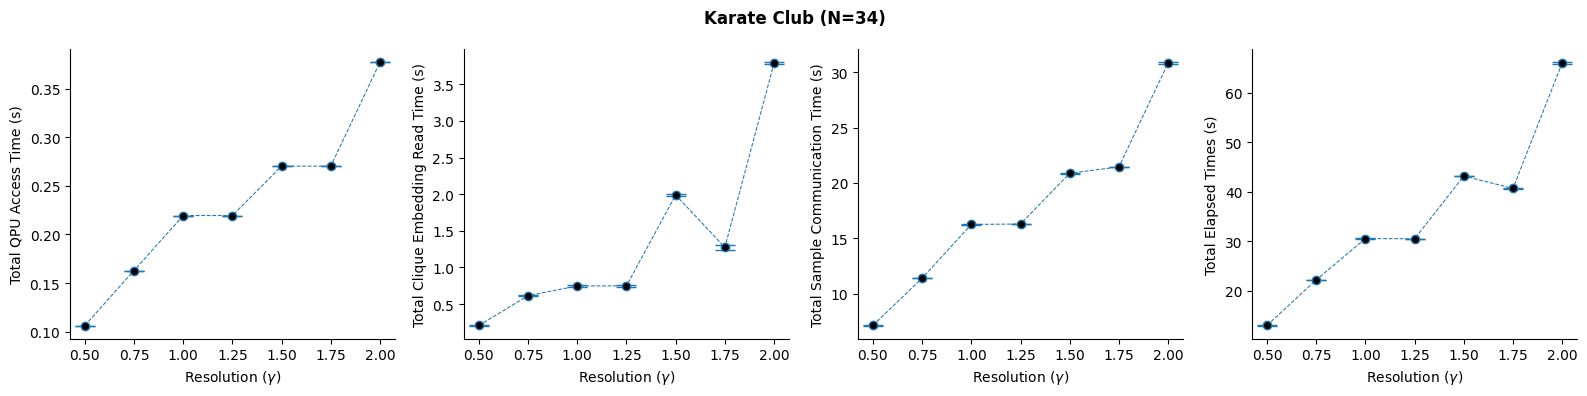

In [4]:
labels = [
    "Total QPU Access Time (s)",
    "Total Clique Embedding Read Time (s)",
    "Total Sample Communication Time (s)",
    "Total Elapsed Times (s)"
]

data = [
    qpu_total_access_time,
    clique_emb_read_total_time,
    sample_communication_total_time,
    elapsed_times
]

# Plot setup
fig, axes = plt.subplots(1, 4, figsize=(16,4), sharex=True)

for ax, times, label in zip(axes, data, labels):
    ax.errorbar(
        resolutions, 
        times[:, 0], 
        yerr=times[:, 1], 
        fmt='o--', 
        capsize=7.5, 
        lw=.75,
        markerfacecolor="black"
    )

    ax.spines[["top","right"]].set_visible(False)
    ax.set_ylabel(label)
    ax.set_xlabel("Resolution ("+r'$\gamma$'+")")
    ax.set_xticks(resolutions)

fig.suptitle("Karate Club (N=34)", fontweight="bold")
fig.tight_layout()
plt.savefig("./Anneal-Times/Karate/Computing-Times.svg", format='svg', dpi=300)

# Power-law clustered networks

In [5]:
os.makedirs("./Anneal-Times/Power-Law", exist_ok=True)

num_reads = 100
version = "Advantage_system6.4"
region = "na-west-1"
num_runs = 20
num_nodes = [10,20,30,50,80,100,120,140]
m, p = 1, .1
resolution = 1

try:
    Graphs = np.load(f"./Anneal-Times/Power-Law/PL-graphs_NODES--{num_nodes[0]}-{num_nodes[-1]}_m-{m}_p-{p}.npy", allow_pickle=True)
    print("Networks loaded")
except:
    Graphs = np.empty(shape=(len(num_nodes),), dtype=object)
    for i, n in enumerate(num_nodes):
        Graphs[i] = nx.powerlaw_cluster_graph(n=n, m=m, p=p)
    np.save(f"./Anneal-Times/Power-Law/PL-graphs_NODES--{num_nodes[0]}-{num_nodes[-1]}_m-{m}_p-{p}.npy", Graphs)
    print("Networks saved")

Networks loaded


### Annealing times of a single division

In [6]:
qpu_total_access_time = np.zeros((len(num_nodes),))
clique_emb_read_total_time = np.zeros((len(num_nodes),))
sample_communication_total_time = np.zeros((len(num_nodes),))
elapsed_times = np.zeros((len(num_nodes),))
max_mods = np.zeros((len(num_nodes),))

with open(f"./Anneal-Times/Power-Law/summary-results_initial-division.txt", 'w') as file:
    for it, nodes in enumerate(num_nodes):
        try: 
            import pickle
            communities, modularities, times, division_trees, division_modularities = (
                np.load(f"./Anneal-Times/Power-Law/PW_n-{nodes}_communities.npy", allow_pickle=True), 
                np.load(f"./Anneal-Times/Power-Law/PW_n-{nodes}_modularities.npy", allow_pickle=True),
                np.load(f"./Anneal-Times/Power-Law/PW_n-{nodes}_times.npy", allow_pickle=True),
                np.load(f"./Anneal-Times/Power-Law/PW_n-{nodes}_division_trees.npy", allow_pickle=True), 
                np.load(f"./Anneal-Times/Power-Law/PW_n-{nodes}_division_modularities.npy", allow_pickle=True)
            )
            with open(f"./Anneal-Times/Power-Law/PW_n-{nodes}_samplesets_data.pkl", 'rb') as f:
                sampleset_data = pickle.load(f)
            
            print("Loaded results for nodes", nodes)
                
        except:
            print("Computing results for nodes", nodes, "( Check --> N =", len(Graphs[it].nodes()),")")

            advantage = AdvantageSampler(
                Graphs[it], # Be careful when modifying the loop to process the correct network
                resolution=resolution,
                num_reads=num_reads, 
                version=version, 
                region=region, 
                use_clique_embedding=True, 
                return_sampleset_metadata=True, 
                elapse_times=True
            )
            iterative_searcher = IterativeSearcher(sampler=advantage)

            res = iterative_searcher.run_with_sampleset_info(
                num_runs=num_runs,
                save_results=True,
                saving_path = f"./Anneal-Times/Power-Law/PW_n-{nodes}",
                iterative_verbosity=0,
                return_sampleset_metadata=True,
            )

            communities, modularities, times, division_trees, division_modularities, sampleset_data = (
                res.communities, 
                res.modularity, 
                res.time, 
                res.division_tree, 
                res.division_modularities, 
                res.samplesets_data
            )
            #break
        id_max = np.argmax(modularities)
        max_mods[it] = modularities.max()
        elapsed_times[it] = times[id_max]
        info = sampleset_data[id_max]

        # Readout is in microseconds, but only from the first division --> Ignore the entire tree
        qpu_sampling_time_us = info.dwave_sampleset_metadata.qpu_sampling_time_us[0] / 1e6
        qpu_anneal_time_per_sample_us = info.dwave_sampleset_metadata.qpu_anneal_time_per_sample_us[0] / 1e6 
        qpu_readout_time_per_sample_us = info.dwave_sampleset_metadata.qpu_readout_time_per_sample_us[0] / 1e6 
        qpu_access_times = info.dwave_sampleset_metadata.qpu_access_time_us[0] / 1e6 
        qpu_access_overhead_time_us = info.dwave_sampleset_metadata.qpu_access_overhead_time_us[0] / 1e6 
        qpu_programming_time_us = info.dwave_sampleset_metadata.qpu_programming_time_us[0] / 1e6 
        qpu_delay_time_per_sample_us = info.dwave_sampleset_metadata.qpu_delay_time_per_sample_us[0] / 1e6
        total_postprocess_time = info.dwave_sampleset_metadata.total_post_processing_time_us[0] / 1e6
                                       
        # Readout is in seconds, but only from the first division --> Ignore the entire tree
        clique_emb_read_time = info.time_measurements[0][0]
        sample_communication = info.time_measurements[0][2]

        file.write(f"Max modularity N={nodes} --> {max_mods[it].round(6)}\n")
        file.write("\n")
        file.write(f"Total QPU sampling time:  {qpu_sampling_time_us} (s)\n")
        file.write(f"Total QPU anneal time per sample  {qpu_anneal_time_per_sample_us} (s)\n")
        file.write(f"Total QPU readout time per sample:  {qpu_readout_time_per_sample_us} (s)\n")
        file.write(f"Total QPU access time:  {qpu_access_times}(s)\n")
        file.write(f"Total QPU access overhead time:  {qpu_access_overhead_time_us} (s)\n")
        file.write(f"Total QPU programming time:  {qpu_programming_time_us} (s)\n")
        file.write(f"Total QPU delay time per sample:  {qpu_delay_time_per_sample_us} (s)\n")
        file.write(f"Total post-processing time:  {total_postprocess_time} (s)\n")
        file.write("\n")
        file.write(f"Total cache-and-read embedding time:  {clique_emb_read_time} (s)\n")
        file.write(f"Total solver communication time:  {sample_communication} (s)\n")
        file.write("x"*50+"\n")

        # Letś record the quantities of interes
        qpu_total_access_time[it] = qpu_access_times
        clique_emb_read_total_time[it] = clique_emb_read_time
        sample_communication_total_time[it] = sample_communication

Loaded results for nodes 10
Loaded results for nodes 20
Loaded results for nodes 30
Loaded results for nodes 50
Loaded results for nodes 80
Loaded results for nodes 100
Loaded results for nodes 120
Loaded results for nodes 140


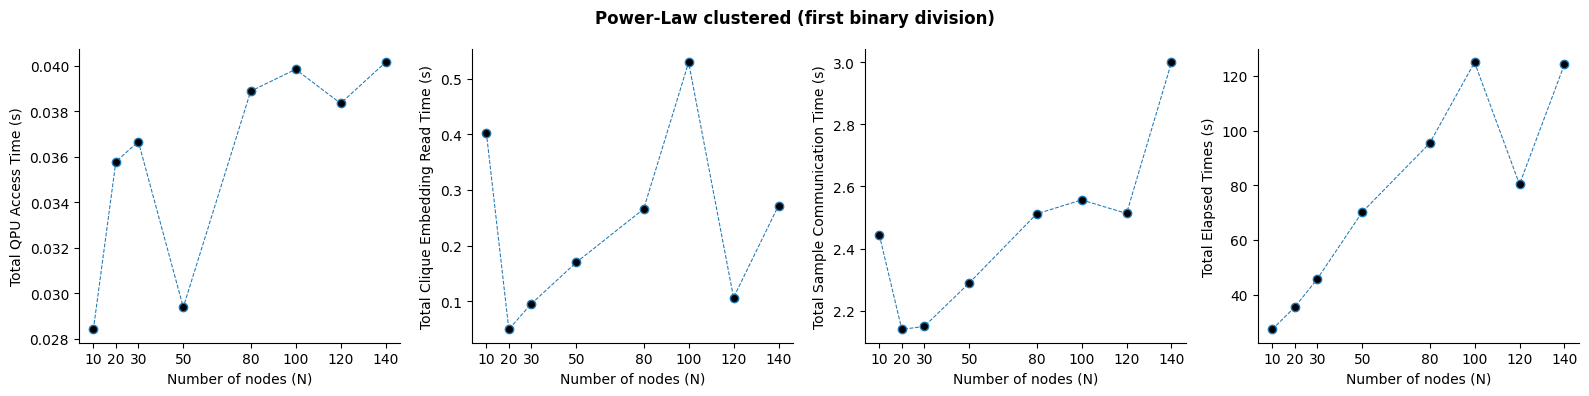

In [7]:
labels = [
    "Total QPU Access Time (s)",
    "Total Clique Embedding Read Time (s)",
    "Total Sample Communication Time (s)",
    "Total Elapsed Times (s)"
]

data = [
    qpu_total_access_time,
    clique_emb_read_total_time,
    sample_communication_total_time,
    elapsed_times
]

# Plot setup
fig, axes = plt.subplots(1, 4, figsize=(16,4), sharex=True)

for ax, times, label in zip(axes, data, labels):
    ax.plot(
        num_nodes, 
        times, 
        'o--', 
        lw=.75,
        markerfacecolor="black"
    )

    ax.spines[["top","right"]].set_visible(False)
    ax.set_ylabel(label)
    ax.set_xlabel("Number of nodes (N)")
    ax.set_xticks(num_nodes)

fig.suptitle("Power-Law clustered (first binary division)", fontweight="bold")
fig.tight_layout()
plt.savefig("./Anneal-Times/Power-Law/Computing-Times_initial-division.svg", format='svg', dpi=300)

### Annealing times for the entire recursion

In [8]:
qpu_total_access_time = np.zeros((len(num_nodes),))
clique_emb_read_total_time = np.zeros((len(num_nodes),))
sample_communication_total_time = np.zeros((len(num_nodes),))
elapsed_times = np.zeros((len(num_nodes),))
max_mods = np.zeros((len(num_nodes),))

with open(f"./Anneal-Times/Power-Law/summary-results_full-recursion.txt", 'w') as file:
    for it, nodes in enumerate(num_nodes):
        try: 
            import pickle
            communities, modularities, times, division_trees, division_modularities = (
                np.load(f"./Anneal-Times/Power-Law/PW_n-{nodes}_communities.npy", allow_pickle=True), 
                np.load(f"./Anneal-Times/Power-Law/PW_n-{nodes}_modularities.npy", allow_pickle=True),
                np.load(f"./Anneal-Times/Power-Law/PW_n-{nodes}_times.npy", allow_pickle=True),
                np.load(f"./Anneal-Times/Power-Law/PW_n-{nodes}_division_trees.npy", allow_pickle=True), 
                np.load(f"./Anneal-Times/Power-Law/PW_n-{nodes}_division_modularities.npy", allow_pickle=True)
            )
            with open(f"./Anneal-Times/Power-Law/PW_n-{nodes}_samplesets_data.pkl", 'rb') as f:
                sampleset_data = pickle.load(f)
            
            print("Loaded results for nodes", nodes)
                
        except:
            print("Computing results for nodes", nodes, "( Check --> N =", len(Graphs[it].nodes()),")")

            advantage = AdvantageSampler(
                Graphs[it], # Be careful when modifying the loop to process the correct network
                resolution=resolution,
                num_reads=num_reads, 
                version=version, 
                region=region, 
                use_clique_embedding=True, 
                return_sampleset_metadata=True, 
                elapse_times=True
            )
            iterative_searcher = IterativeSearcher(sampler=advantage)

            res = iterative_searcher.run_with_sampleset_info(
                num_runs=num_runs,
                save_results=True,
                saving_path = f"./Anneal-Times/Power-Law/PW_n-{nodes}",
                iterative_verbosity=0,
                return_sampleset_metadata=True,
            )

            communities, modularities, times, division_trees, division_modularities, sampleset_data = (
                res.communities, 
                res.modularity, 
                res.time, 
                res.division_tree, 
                res.division_modularities, 
                res.samplesets_data
            )
        id_max = np.argmax(modularities)
        max_mods[it] = modularities.max()
        elapsed_times[it] = times[id_max]
        info = sampleset_data[id_max]

        # Readout is in microseconds, but only from the first division --> Ignore the entire tree
        qpu_sampling_time_us = sum( info.dwave_sampleset_metadata.qpu_sampling_time_us / 1e6 )
        qpu_anneal_time_per_sample_us = sum( info.dwave_sampleset_metadata.qpu_anneal_time_per_sample_us / 1e6 )
        qpu_readout_time_per_sample_us = sum( info.dwave_sampleset_metadata.qpu_readout_time_per_sample_us / 1e6 )
        qpu_access_times = sum( info.dwave_sampleset_metadata.qpu_access_time_us / 1e6 )
        qpu_access_overhead_time_us = sum( info.dwave_sampleset_metadata.qpu_access_overhead_time_us / 1e6 )
        qpu_programming_time_us = sum( info.dwave_sampleset_metadata.qpu_programming_time_us / 1e6 )
        qpu_delay_time_per_sample_us = sum( info.dwave_sampleset_metadata.qpu_delay_time_per_sample_us / 1e6 )
        total_postprocess_time = sum( info.dwave_sampleset_metadata.total_post_processing_time_us / 1e6 )
                                       
        # Readout is in seconds, but only from the first division --> Ignore the entire tree
        clique_emb_read_time = sum( [info.time_measurements[i][0] for i in range(len(division_trees[id_max]))] )
        sample_communication = sum( [info.time_measurements[i][2] for i in range(len(division_trees[id_max]))] )

        file.write(f"Max modularity N={nodes} --> {max_mods[it].round(6)}\n")
        file.write("\n")
        file.write(f"Total QPU sampling time:  {qpu_sampling_time_us} (s)\n")
        file.write(f"Total QPU anneal time per sample  {qpu_anneal_time_per_sample_us} (s)\n")
        file.write(f"Total QPU readout time per sample:  {qpu_readout_time_per_sample_us} (s)\n")
        file.write(f"Total QPU access time:  {qpu_access_times}(s)\n")
        file.write(f"Total QPU access overhead time:  {qpu_access_overhead_time_us} (s)\n")
        file.write(f"Total QPU programming time:  {qpu_programming_time_us} (s)\n")
        file.write(f"Total QPU delay time per sample:  {qpu_delay_time_per_sample_us} (s)\n")
        file.write(f"Total post-processing time:  {total_postprocess_time} (s)\n")
        file.write("\n")
        file.write(f"Total cache-and-read embedding time:  {clique_emb_read_time} (s)\n")
        file.write(f"Total solver communication time:  {sample_communication} (s)\n")
        file.write("x"*50+"\n")

        # Letś record the quantities of interes
        qpu_total_access_time[it] = qpu_access_times
        clique_emb_read_total_time[it] = clique_emb_read_time
        sample_communication_total_time[it] = sample_communication

Loaded results for nodes 10
Loaded results for nodes 20
Loaded results for nodes 30
Loaded results for nodes 50
Loaded results for nodes 80
Loaded results for nodes 100
Loaded results for nodes 120
Loaded results for nodes 140


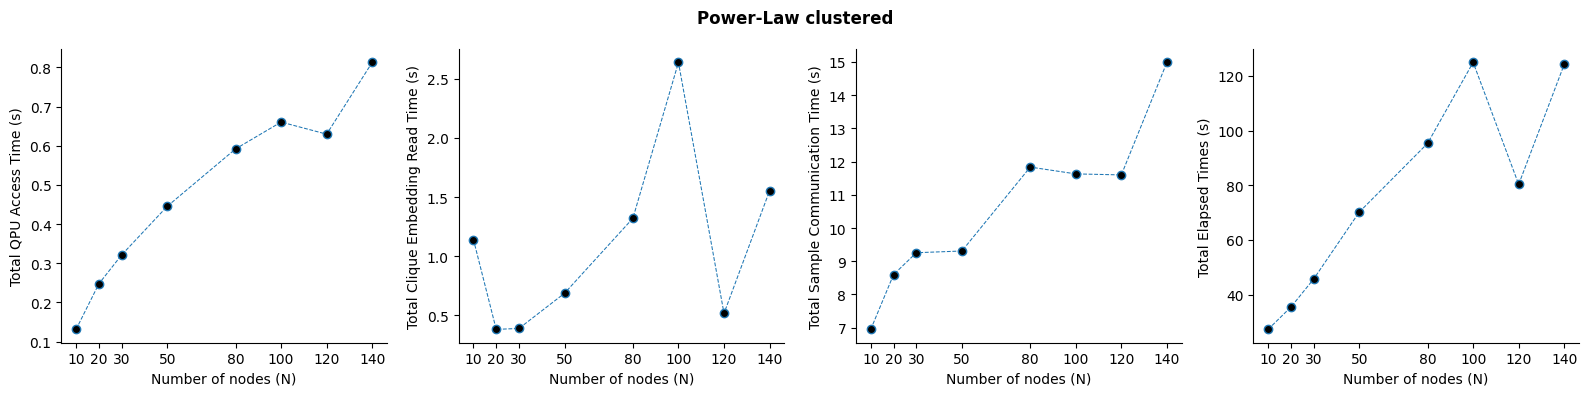

In [9]:
labels = [
    "Total QPU Access Time (s)",
    "Total Clique Embedding Read Time (s)",
    "Total Sample Communication Time (s)",
    "Total Elapsed Times (s)"
]

data = [
    qpu_total_access_time,
    clique_emb_read_total_time,
    sample_communication_total_time,
    elapsed_times
]

# Plot setup
fig, axes = plt.subplots(1, 4, figsize=(16,4), sharex=True)

for ax, times, label in zip(axes, data, labels):
    ax.plot(
        num_nodes, 
        times, 
        'o--', 
        lw=.75,
        markerfacecolor="black"
    )

    ax.spines[["top","right"]].set_visible(False)
    ax.set_ylabel(label)
    ax.set_xlabel("Number of nodes (N)")
    ax.set_xticks(num_nodes)

fig.suptitle("Power-Law clustered", fontweight="bold")
fig.tight_layout()
plt.savefig("./Anneal-Times/Power-Law/Computing-Times_full-recursion.svg", format='svg', dpi=300)

### Resolutions

In [10]:
resolutions = [.5, .75, 1.25, 1.5]#1, 
nodes_resolutions = [50, 80, 100]
qpu_total_access_time_resos = np.zeros((len(resolutions),len(nodes_resolutions)))
clique_emb_read_total_time_resos = np.zeros((len(resolutions),len(nodes_resolutions)))
sample_communication_total_time_resos = np.zeros((len(resolutions),len(nodes_resolutions)))
elapsed_times_resos = np.zeros((len(resolutions),len(nodes_resolutions)))
max_mods_resos = np.zeros((len(resolutions),len(nodes_resolutions)))
nodes2graph = {
    10: 0,
    20: 1,
    30: 2,
    50: 3,
    80: 4,
    100: 5,
    120: 6,
    140: 7,
}

with open(f"./Anneal-Times/Power-Law/summary-results_full-recursion_resolutions.txt", 'w') as file:
    for jt, nodes in enumerate(nodes_resolutions): 
        it_gr = nodes2graph[nodes]
        for it, resolution in enumerate(resolutions):
            if resolution==1:
                text = ""
            else:
                text = f'res-{resolution}'
            try: 
                import pickle
                communities, modularities, times, division_trees, division_modularities = (
                    np.load(f"./Anneal-Times/Power-Law/PW_n-{nodes}{text}_communities.npy", allow_pickle=True), 
                    np.load(f"./Anneal-Times/Power-Law/PW_n-{nodes}{text}_modularities.npy", allow_pickle=True),
                    np.load(f"./Anneal-Times/Power-Law/PW_n-{nodes}{text}_times.npy", allow_pickle=True),
                    np.load(f"./Anneal-Times/Power-Law/PW_n-{nodes}{text}_division_trees.npy", allow_pickle=True), 
                    np.load(f"./Anneal-Times/Power-Law/PW_n-{nodes}{text}_division_modularities.npy", allow_pickle=True)
                )
                with open(f"./Anneal-Times/Power-Law/PW_n-{nodes}{text}_samplesets_data.pkl", 'rb') as f:
                    sampleset_data = pickle.load(f)
                
                print("Loaded results for", nodes, "and resolution ", resolution)
                    
            except:
                print("Computing results for nodes", nodes, "and resolution ", resolution, "( Check --> N =", len(Graphs[it_gr].nodes()),")")

                advantage = AdvantageSampler(
                    Graphs[it_gr], # Be careful when modifying the loop to process the correct network
                    resolution=resolution,
                    num_reads=num_reads, 
                    version=version, 
                    region=region, 
                    use_clique_embedding=True, 
                    return_sampleset_metadata=True, 
                    elapse_times=True
                )
                iterative_searcher = IterativeSearcher(sampler=advantage)

                res = iterative_searcher.run_with_sampleset_info(
                    num_runs=num_runs,
                    save_results=True,
                    saving_path = f"./Anneal-Times/Power-Law/PW_n-{nodes}{text}",
                    iterative_verbosity=0,
                    return_sampleset_metadata=True,
                )

                communities, modularities, times, division_trees, division_modularities, sampleset_data = (
                    res.communities, 
                    res.modularity, 
                    res.time, 
                    res.division_tree, 
                    res.division_modularities, 
                    res.samplesets_data
                )
                break
                
            id_max = np.argmax(modularities)
            max_mods_resos[it,jt] = modularities.max()
            elapsed_times_resos[it,jt] = times[id_max]
            info = sampleset_data[id_max]

            # Readout is in microseconds, but only from the first division --> Ignore the entire tree
            qpu_sampling_time_us = sum( info.dwave_sampleset_metadata.qpu_sampling_time_us / 1e6 )
            qpu_anneal_time_per_sample_us = sum( info.dwave_sampleset_metadata.qpu_anneal_time_per_sample_us / 1e6 )
            qpu_readout_time_per_sample_us = sum( info.dwave_sampleset_metadata.qpu_readout_time_per_sample_us / 1e6 )
            qpu_access_times = sum( info.dwave_sampleset_metadata.qpu_access_time_us / 1e6 )
            qpu_access_overhead_time_us = sum( info.dwave_sampleset_metadata.qpu_access_overhead_time_us / 1e6 )
            qpu_programming_time_us = sum( info.dwave_sampleset_metadata.qpu_programming_time_us / 1e6 )
            qpu_delay_time_per_sample_us = sum( info.dwave_sampleset_metadata.qpu_delay_time_per_sample_us / 1e6 )
            total_postprocess_time = sum( info.dwave_sampleset_metadata.total_post_processing_time_us / 1e6 )
                                        
            # Readout is in seconds, but only from the first division --> Ignore the entire tree
            clique_emb_read_time = sum( [info.time_measurements[i][0] for i in range(len(division_trees[id_max]))] )
            sample_communication = sum( [info.time_measurements[i][2] for i in range(len(division_trees[id_max]))] )

            file.write(f"Max modularity N={nodes} and resolution={resolution} --> {max_mods_resos[it].round(6)}\n")
            file.write("\n")
            file.write(f"Total QPU sampling time:  {qpu_sampling_time_us} (s)\n")
            file.write(f"Total QPU anneal time per sample  {qpu_anneal_time_per_sample_us} (s)\n")
            file.write(f"Total QPU readout time per sample:  {qpu_readout_time_per_sample_us} (s)\n")
            file.write(f"Total QPU access time:  {qpu_access_times}(s)\n")
            file.write(f"Total QPU access overhead time:  {qpu_access_overhead_time_us} (s)\n")
            file.write(f"Total QPU programming time:  {qpu_programming_time_us} (s)\n")
            file.write(f"Total QPU delay time per sample:  {qpu_delay_time_per_sample_us} (s)\n")
            file.write(f"Total post-processing time:  {total_postprocess_time} (s)\n")
            file.write("\n")
            file.write(f"Total cache-and-read embedding time:  {clique_emb_read_time} (s)\n")
            file.write(f"Total solver communication time:  {sample_communication} (s)\n")
            file.write("x"*50+"\n")

            # Letś record the quantities of interes
            qpu_total_access_time_resos[it,jt] = qpu_access_times
            clique_emb_read_total_time_resos[it,jt] = clique_emb_read_time
            sample_communication_total_time_resos[it,jt] = sample_communication
        print("")

Loaded results for 50 and resolution  0.5
Loaded results for 50 and resolution  0.75
Loaded results for 50 and resolution  1.25
Loaded results for 50 and resolution  1.5

Loaded results for 80 and resolution  0.5
Loaded results for 80 and resolution  0.75
Loaded results for 80 and resolution  1.25
Loaded results for 80 and resolution  1.5

Loaded results for 100 and resolution  0.5
Loaded results for 100 and resolution  0.75
Loaded results for 100 and resolution  1.25
Loaded results for 100 and resolution  1.5



### Plots

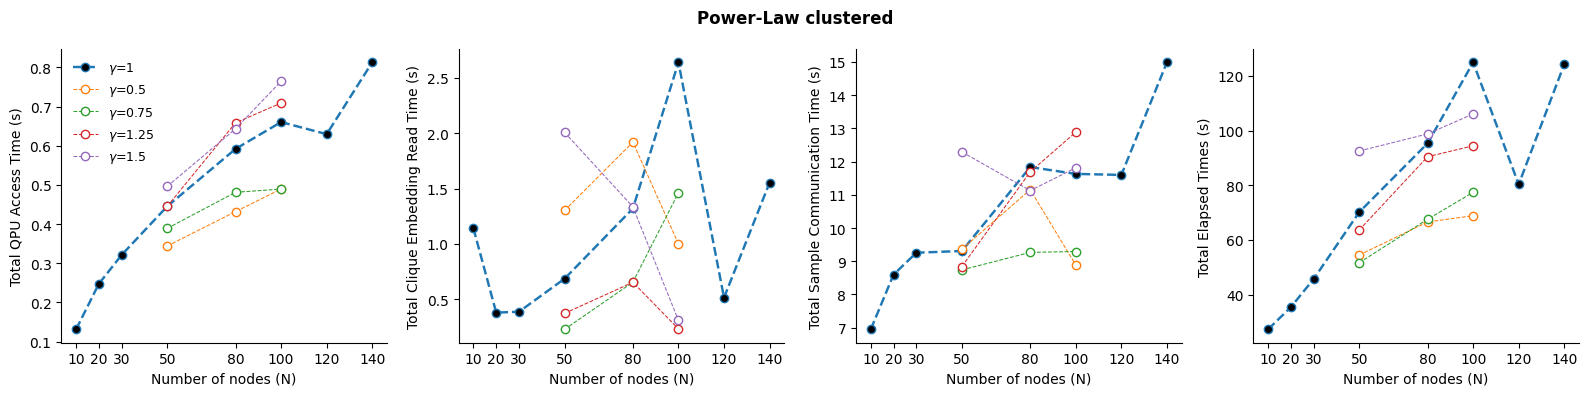

In [11]:
labels = [
    "Total QPU Access Time (s)",
    "Total Clique Embedding Read Time (s)",
    "Total Sample Communication Time (s)",
    "Total Elapsed Times (s)"
]

data = [
    qpu_total_access_time,
    clique_emb_read_total_time,
    sample_communication_total_time,
    elapsed_times
]
data_resos = [
    qpu_total_access_time_resos,
    clique_emb_read_total_time_resos,
    sample_communication_total_time_resos,
    elapsed_times_resos
]

# Plot setup
fig, axes = plt.subplots(1, 4, figsize=(16,4), sharex=True)

for ii, (ax, times, ll) in enumerate(zip(axes, data, labels)):
    ax.plot(
        num_nodes, 
        times, 
        'o--', 
        lw=1.75,
        markerfacecolor="black",
        label=r'$\gamma$'+f"=1"
    )
    for i, g in enumerate(resolutions):
        ax.plot(
            nodes_resolutions, 
            data_resos[ii][i,:], 
            'o--', 
            lw=.75,
            markerfacecolor="white",
            label=r'$\gamma$'+f"={g}"
        )

    ax.spines[["top","right"]].set_visible(False)
    ax.set_ylabel(ll)
    ax.set_xlabel("Number of nodes (N)")
    ax.set_xticks(num_nodes)
    if ii==0:
        ax.legend(frameon=False, ncol=1, fontsize=9)

fig.suptitle("Power-Law clustered", fontweight="bold")
fig.tight_layout()
plt.savefig("./Anneal-Times/Power-Law/Computing-Times_full-recursion.svg", format='svg', dpi=300)

# Barabasi-Albert networks

In [12]:
os.makedirs("./Anneal-Times/Barbasi-Albert", exist_ok=True)

num_reads = 100
version = "Advantage_system6.4"
region = "na-west-1"
num_runs = 20
num_nodes = [10,20,30,50,80,100,120,140]
m = .4
resolution = 1

try:
    Graphs = np.load(f"./Anneal-Times/Barbasi-Albert/BA-graphs_NODES--{num_nodes[0]}-{num_nodes[-1]}_m-{m}.npy", allow_pickle=True)
    print("Networks loaded")
except:
    Graphs = np.empty(shape=(len(num_nodes),), dtype=object)
    for i, n in enumerate(num_nodes):
        Graphs[i] = nx.barabasi_albert_graph(n=n, m=int(n*m))
    np.save(f"./Anneal-Times/Barbasi-Albert/BA-graphs_NODES--{num_nodes[0]}-{num_nodes[-1]}_m-{m}.npy", Graphs)
    print("Networks saved")

Networks loaded


### Annealing times of a single division

In [13]:
qpu_total_access_time = np.zeros((len(num_nodes),))
clique_emb_read_total_time = np.zeros((len(num_nodes),))
sample_communication_total_time = np.zeros((len(num_nodes),))
elapsed_times = np.zeros((len(num_nodes),))
max_mods = np.zeros((len(num_nodes),))

with open(f"./Anneal-Times/Barbasi-Albert/summary-results_initial-division.txt", 'w') as file:
    for it, nodes in enumerate(num_nodes):
        try: 
            import pickle
            communities, modularities, times, division_trees, division_modularities = (
                np.load(f"./Anneal-Times/Barbasi-Albert/BA_n-{nodes}_communities.npy", allow_pickle=True), 
                np.load(f"./Anneal-Times/Barbasi-Albert/BA_n-{nodes}_modularities.npy", allow_pickle=True),
                np.load(f"./Anneal-Times/Barbasi-Albert/BA_n-{nodes}_times.npy", allow_pickle=True),
                np.load(f"./Anneal-Times/Barbasi-Albert/BA_n-{nodes}_division_trees.npy", allow_pickle=True), 
                np.load(f"./Anneal-Times/Barbasi-Albert/BA_n-{nodes}_division_modularities.npy", allow_pickle=True)
            )
            with open(f"./Anneal-Times/Barbasi-Albert/BA_n-{nodes}_samplesets_data.pkl", 'rb') as f:
                sampleset_data = pickle.load(f)
            
            print("Loaded results for nodes", nodes)
                
        except:
            print("Computing results for nodes", nodes, "( Check --> N =", len(Graphs[it].nodes()),")")

            advantage = AdvantageSampler(
                Graphs[it], # Be careful when modifying the loop to process the correct network
                resolution=resolution,
                num_reads=num_reads, 
                version=version, 
                region=region, 
                use_clique_embedding=True, 
                return_sampleset_metadata=True, 
                elapse_times=True
            )
            iterative_searcher = IterativeSearcher(sampler=advantage)

            res = iterative_searcher.run_with_sampleset_info(
                num_runs=num_runs,
                save_results=True,
                saving_path = f"./Anneal-Times/Barbasi-Albert/BA_n-{nodes}",
                iterative_verbosity=0,
                return_sampleset_metadata=True,
            )

            communities, modularities, times, division_trees, division_modularities, sampleset_data = (
                res.communities, 
                res.modularity, 
                res.time, 
                res.division_tree, 
                res.division_modularities, 
                res.samplesets_data
            )
        id_max = np.argmax(modularities)
        max_mods[it] = modularities.max()
        elapsed_times[it] = times[id_max]
        info = sampleset_data[id_max]

        # Readout is in microseconds, but only from the first division --> Ignore the entire tree
        qpu_sampling_time_us = info.dwave_sampleset_metadata.qpu_sampling_time_us[0] / 1e6
        qpu_anneal_time_per_sample_us = info.dwave_sampleset_metadata.qpu_anneal_time_per_sample_us[0] / 1e6 
        qpu_readout_time_per_sample_us = info.dwave_sampleset_metadata.qpu_readout_time_per_sample_us[0] / 1e6 
        qpu_access_times = info.dwave_sampleset_metadata.qpu_access_time_us[0] / 1e6 
        qpu_access_overhead_time_us = info.dwave_sampleset_metadata.qpu_access_overhead_time_us[0] / 1e6 
        qpu_programming_time_us = info.dwave_sampleset_metadata.qpu_programming_time_us[0] / 1e6 
        qpu_delay_time_per_sample_us = info.dwave_sampleset_metadata.qpu_delay_time_per_sample_us[0] / 1e6
        total_postprocess_time = info.dwave_sampleset_metadata.total_post_processing_time_us[0] / 1e6
                                       
        # Readout is in seconds, but only from the first division --> Ignore the entire tree
        clique_emb_read_time = info.time_measurements[0][0]
        sample_communication = info.time_measurements[0][2]

        file.write(f"Max modularity N={nodes} --> {max_mods[it].round(6)}\n")
        file.write("\n")
        file.write(f"Total QPU sampling time:  {qpu_sampling_time_us} (s)\n")
        file.write(f"Total QPU anneal time per sample  {qpu_anneal_time_per_sample_us} (s)\n")
        file.write(f"Total QPU readout time per sample:  {qpu_readout_time_per_sample_us} (s)\n")
        file.write(f"Total QPU access time:  {qpu_access_times}(s)\n")
        file.write(f"Total QPU access overhead time:  {qpu_access_overhead_time_us} (s)\n")
        file.write(f"Total QPU programming time:  {qpu_programming_time_us} (s)\n")
        file.write(f"Total QPU delay time per sample:  {qpu_delay_time_per_sample_us} (s)\n")
        file.write(f"Total post-processing time:  {total_postprocess_time} (s)\n")
        file.write("\n")
        file.write(f"Total cache-and-read embedding time:  {clique_emb_read_time} (s)\n")
        file.write(f"Total solver communication time:  {sample_communication} (s)\n")
        file.write("x"*50+"\n")

        # Letś record the quantities of interes
        qpu_total_access_time[it] = qpu_access_times
        clique_emb_read_total_time[it] = clique_emb_read_time
        sample_communication_total_time[it] = sample_communication

Loaded results for nodes 10
Loaded results for nodes 20
Loaded results for nodes 30
Loaded results for nodes 50
Loaded results for nodes 80
Loaded results for nodes 100
Loaded results for nodes 120
Loaded results for nodes 140


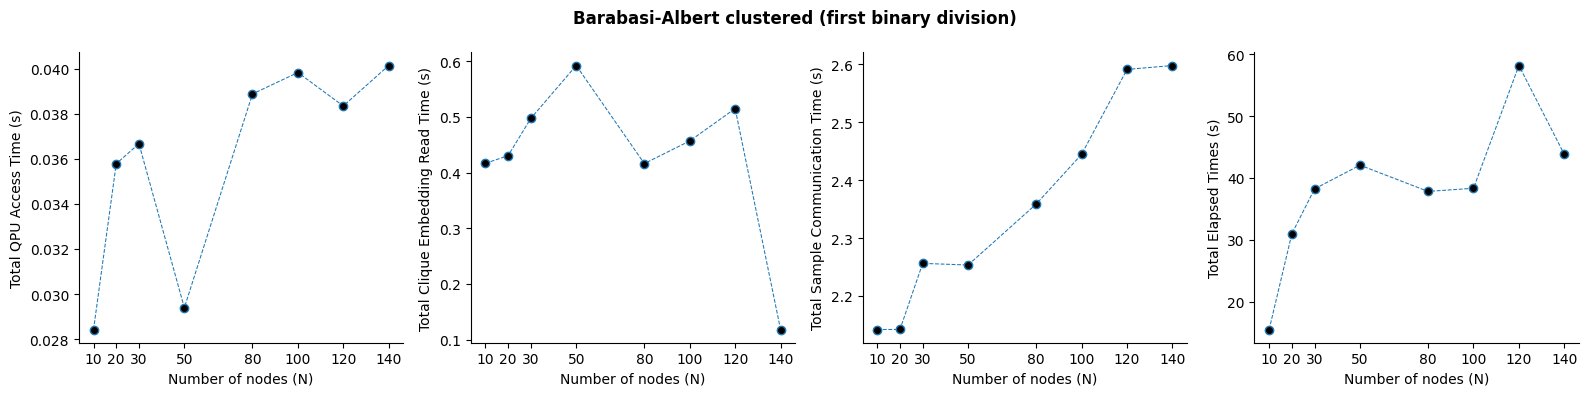

In [14]:
labels = [
    "Total QPU Access Time (s)",
    "Total Clique Embedding Read Time (s)",
    "Total Sample Communication Time (s)",
    "Total Elapsed Times (s)"
]

data = [
    qpu_total_access_time,
    clique_emb_read_total_time,
    sample_communication_total_time,
    elapsed_times
]

# Plot setup
fig, axes = plt.subplots(1, 4, figsize=(16,4), sharex=True)

for ax, times, label in zip(axes, data, labels):
    ax.plot(
        num_nodes, 
        times, 
        'o--', 
        lw=.75,
        markerfacecolor="black"
    )

    ax.spines[["top","right"]].set_visible(False)
    ax.set_ylabel(label)
    ax.set_xlabel("Number of nodes (N)")
    ax.set_xticks(num_nodes)

fig.suptitle("Barabasi-Albert clustered (first binary division)", fontweight="bold")
fig.tight_layout()
plt.savefig("./Anneal-Times/Barbasi-Albert/Computing-Times_initial-division.svg", format='svg', dpi=300)

### Annealing times for the enitre recursion

In [15]:
qpu_total_access_time = np.zeros((len(num_nodes),))
clique_emb_read_total_time = np.zeros((len(num_nodes),))
sample_communication_total_time = np.zeros((len(num_nodes),))
elapsed_times = np.zeros((len(num_nodes),))
max_mods = np.zeros((len(num_nodes),))

with open(f"./Anneal-Times/Barbasi-Albert/summary-results_full-recursion.txt", 'w') as file:
    for it, nodes in enumerate(num_nodes):
        try: 
            import pickle
            communities, modularities, times, division_trees, division_modularities = (
                np.load(f"./Anneal-Times/Barbasi-Albert/BA_n-{nodes}_communities.npy", allow_pickle=True), 
                np.load(f"./Anneal-Times/Barbasi-Albert/BA_n-{nodes}_modularities.npy", allow_pickle=True),
                np.load(f"./Anneal-Times/Barbasi-Albert/BA_n-{nodes}_times.npy", allow_pickle=True),
                np.load(f"./Anneal-Times/Barbasi-Albert/BA_n-{nodes}_division_trees.npy", allow_pickle=True), 
                np.load(f"./Anneal-Times/Barbasi-Albert/BA_n-{nodes}_division_modularities.npy", allow_pickle=True)
            )
            with open(f"./Anneal-Times/Barbasi-Albert/BA_n-{nodes}_samplesets_data.pkl", 'rb') as f:
                sampleset_data = pickle.load(f)
            
            print("Loaded results for nodes", nodes)
                
        except:
            print("Computing results for nodes", nodes, "( Check --> N =", len(Graphs[it].nodes()),")")

            advantage = AdvantageSampler(
                Graphs[it], # Be careful when modifying the loop to process the correct network
                resolution=resolution,
                num_reads=num_reads, 
                version=version, 
                region=region, 
                use_clique_embedding=True, 
                return_sampleset_metadata=True, 
                elapse_times=True
            )
            iterative_searcher = IterativeSearcher(sampler=advantage)

            res = iterative_searcher.run_with_sampleset_info(
                num_runs=num_runs,
                save_results=True,
                saving_path = f"./Anneal-Times/Barbasi-Albert/BA_n-{nodes}",
                iterative_verbosity=0,
                return_sampleset_metadata=True,
            )

            communities, modularities, times, division_trees, division_modularities, sampleset_data = (
                res.communities, 
                res.modularity, 
                res.time, 
                res.division_tree, 
                res.division_modularities, 
                res.samplesets_data
            )
        id_max = np.argmax(modularities)
        max_mods[it] = modularities.max()
        elapsed_times[it] = times[id_max]
        info = sampleset_data[id_max]

        # Readout is in microseconds, but only from the first division --> Ignore the entire tree
        qpu_sampling_time_us = sum( info.dwave_sampleset_metadata.qpu_sampling_time_us / 1e6 )
        qpu_anneal_time_per_sample_us = sum( info.dwave_sampleset_metadata.qpu_anneal_time_per_sample_us / 1e6 )
        qpu_readout_time_per_sample_us = sum( info.dwave_sampleset_metadata.qpu_readout_time_per_sample_us / 1e6 )
        qpu_access_times = sum( info.dwave_sampleset_metadata.qpu_access_time_us / 1e6 )
        qpu_access_overhead_time_us = sum( info.dwave_sampleset_metadata.qpu_access_overhead_time_us / 1e6 )
        qpu_programming_time_us = sum( info.dwave_sampleset_metadata.qpu_programming_time_us / 1e6 )
        qpu_delay_time_per_sample_us = sum( info.dwave_sampleset_metadata.qpu_delay_time_per_sample_us / 1e6 )
        total_postprocess_time = sum( info.dwave_sampleset_metadata.total_post_processing_time_us / 1e6 )
                                       
        # Readout is in seconds, but only from the first division --> Ignore the entire tree
        clique_emb_read_time = sum( [info.time_measurements[i][0] for i in range(len(division_trees[id_max]))] )
        sample_communication = sum( [info.time_measurements[i][2] for i in range(len(division_trees[id_max]))] )

        file.write(f"Max modularity N={nodes} --> {max_mods[it].round(6)}\n")
        file.write("\n")
        file.write(f"Total QPU sampling time:  {qpu_sampling_time_us} (s)\n")
        file.write(f"Total QPU anneal time per sample  {qpu_anneal_time_per_sample_us} (s)\n")
        file.write(f"Total QPU readout time per sample:  {qpu_readout_time_per_sample_us} (s)\n")
        file.write(f"Total QPU access time:  {qpu_access_times}(s)\n")
        file.write(f"Total QPU access overhead time:  {qpu_access_overhead_time_us} (s)\n")
        file.write(f"Total QPU programming time:  {qpu_programming_time_us} (s)\n")
        file.write(f"Total QPU delay time per sample:  {qpu_delay_time_per_sample_us} (s)\n")
        file.write(f"Total post-processing time:  {total_postprocess_time} (s)\n")
        file.write("\n")
        file.write(f"Total cache-and-read embedding time:  {clique_emb_read_time} (s)\n")
        file.write(f"Total solver communication time:  {sample_communication} (s)\n")
        file.write("x"*50+"\n")

        # Letś record the quantities of interes
        qpu_total_access_time[it] = qpu_access_times
        clique_emb_read_total_time[it] = clique_emb_read_time
        sample_communication_total_time[it] = sample_communication

Loaded results for nodes 10
Loaded results for nodes 20
Loaded results for nodes 30
Loaded results for nodes 50
Loaded results for nodes 80
Loaded results for nodes 100
Loaded results for nodes 120
Loaded results for nodes 140


### Resolutions

In [ ]:
resolutions = [.5, .75, 1.25, 1.5]#1, 
nodes_resolutions = [50, 80, 100]
qpu_total_access_time_resos = np.zeros((len(resolutions),len(nodes_resolutions)))
clique_emb_read_total_time_resos = np.zeros((len(resolutions),len(nodes_resolutions)))
sample_communication_total_time_resos = np.zeros((len(resolutions),len(nodes_resolutions)))
elapsed_times_resos = np.zeros((len(resolutions),len(nodes_resolutions)))
max_mods_resos = np.zeros((len(resolutions),len(nodes_resolutions)))
nodes2graph = {
    10: 0,
    20: 1,
    30: 2,
    50: 3,
    80: 4,
    100: 5,
    120: 6,
    140: 7,
}

with open(f"./Anneal-Times/Barbasi-Albert/summary-results_full-recursion_resolutions.txt", 'w') as file:
    for jt, nodes in enumerate(nodes_resolutions): 
        it_gr = nodes2graph[nodes]
        for it, resolution in enumerate(resolutions):
            if resolution==1:
                text = ""
            else:
                text = f'res-{resolution}'
            try: 
                import pickle
                communities, modularities, times, division_trees, division_modularities = (
                    np.load(f"./Anneal-Times/Barbasi-Albert/BA_n-{nodes}{text}_communities.npy", allow_pickle=True), 
                    np.load(f"./Anneal-Times/Barbasi-Albert/BA_n-{nodes}{text}_modularities.npy", allow_pickle=True),
                    np.load(f"./Anneal-Times/Barbasi-Albert/BA_n-{nodes}{text}_times.npy", allow_pickle=True),
                    np.load(f"./Anneal-Times/Barbasi-Albert/BA_n-{nodes}{text}_division_trees.npy", allow_pickle=True), 
                    np.load(f"./Anneal-Times/Barbasi-Albert/BA_n-{nodes}{text}_division_modularities.npy", allow_pickle=True)
                )
                with open(f"./Anneal-Times/Barbasi-Albert/BA_n-{nodes}{text}_samplesets_data.pkl", 'rb') as f:
                    sampleset_data = pickle.load(f)
                
                print("Loaded results for", nodes, "and resolution ", resolution)
                    
            except:
                print("Computing results for nodes", nodes, "and resolution ", resolution, "( Check --> N =", len(Graphs[it_gr].nodes()),")")

                advantage = AdvantageSampler(
                    Graphs[it_gr], # Be careful when modifying the loop to process the correct network
                    resolution=resolution,
                    num_reads=num_reads, 
                    version=version, 
                    region=region, 
                    use_clique_embedding=True, 
                    return_sampleset_metadata=True, 
                    elapse_times=True
                )
                iterative_searcher = IterativeSearcher(sampler=advantage)

                res = iterative_searcher.run_with_sampleset_info(
                    num_runs=num_runs,
                    save_results=True,
                    saving_path = f"./Anneal-Times/Barbasi-Albert/BA_n-{nodes}{text}",
                    iterative_verbosity=0,
                    return_sampleset_metadata=True,
                )

                communities, modularities, times, division_trees, division_modularities, sampleset_data = (
                    res.communities, 
                    res.modularity, 
                    res.time, 
                    res.division_tree, 
                    res.division_modularities, 
                    res.samplesets_data
                )
                
            id_max = np.argmax(modularities)
            max_mods_resos[it,jt] = modularities.max()
            elapsed_times_resos[it,jt] = times[id_max]
            info = sampleset_data[id_max]

            # Readout is in microseconds, but only from the first division --> Ignore the entire tree
            qpu_sampling_time_us = sum( info.dwave_sampleset_metadata.qpu_sampling_time_us / 1e6 )
            qpu_anneal_time_per_sample_us = sum( info.dwave_sampleset_metadata.qpu_anneal_time_per_sample_us / 1e6 )
            qpu_readout_time_per_sample_us = sum( info.dwave_sampleset_metadata.qpu_readout_time_per_sample_us / 1e6 )
            qpu_access_times = sum( info.dwave_sampleset_metadata.qpu_access_time_us / 1e6 )
            qpu_access_overhead_time_us = sum( info.dwave_sampleset_metadata.qpu_access_overhead_time_us / 1e6 )
            qpu_programming_time_us = sum( info.dwave_sampleset_metadata.qpu_programming_time_us / 1e6 )
            qpu_delay_time_per_sample_us = sum( info.dwave_sampleset_metadata.qpu_delay_time_per_sample_us / 1e6 )
            total_postprocess_time = sum( info.dwave_sampleset_metadata.total_post_processing_time_us / 1e6 )
                                        
            # Readout is in seconds, but only from the first division --> Ignore the entire tree
            clique_emb_read_time = sum( [info.time_measurements[i][0] for i in range(len(division_trees[id_max]))] )
            sample_communication = sum( [info.time_measurements[i][2] for i in range(len(division_trees[id_max]))] )

            file.write(f"Max modularity N={nodes} --> {max_mods_resos[it].round(6)}\n")
            file.write("\n")
            file.write(f"Total QPU sampling time:  {qpu_sampling_time_us} (s)\n")
            file.write(f"Total QPU anneal time per sample  {qpu_anneal_time_per_sample_us} (s)\n")
            file.write(f"Total QPU readout time per sample:  {qpu_readout_time_per_sample_us} (s)\n")
            file.write(f"Total QPU access time:  {qpu_access_times}(s)\n")
            file.write(f"Total QPU access overhead time:  {qpu_access_overhead_time_us} (s)\n")
            file.write(f"Total QPU programming time:  {qpu_programming_time_us} (s)\n")
            file.write(f"Total QPU delay time per sample:  {qpu_delay_time_per_sample_us} (s)\n")
            file.write(f"Total post-processing time:  {total_postprocess_time} (s)\n")
            file.write("\n")
            file.write(f"Total cache-and-read embedding time:  {clique_emb_read_time} (s)\n")
            file.write(f"Total solver communication time:  {sample_communication} (s)\n")
            file.write("x"*50+"\n")

            # Letś record the quantities of interes
            qpu_total_access_time_resos[it,jt] = qpu_access_times
            clique_emb_read_total_time_resos[it,jt] = clique_emb_read_time
            sample_communication_total_time_resos[it,jt] = sample_communication
        print("")

Loaded results for 50 and resolution  0.5
Loaded results for 50 and resolution  0.75
Loaded results for 50 and resolution  1.25
Loaded results for 50 and resolution  1.5

Loaded results for 80 and resolution  0.5
Loaded results for 80 and resolution  0.75
Loaded results for 80 and resolution  1.25
Loaded results for 80 and resolution  1.5

Loaded results for 100 and resolution  0.5
Loaded results for 100 and resolution  0.75
Loaded results for 100 and resolution  1.25
Computing results for nodes 100 and resolution  1.5 ( Check --> N = 100 )


100%|██████████| 20/20 [1:18:29<00:00, 235.49s/it]

### Plots

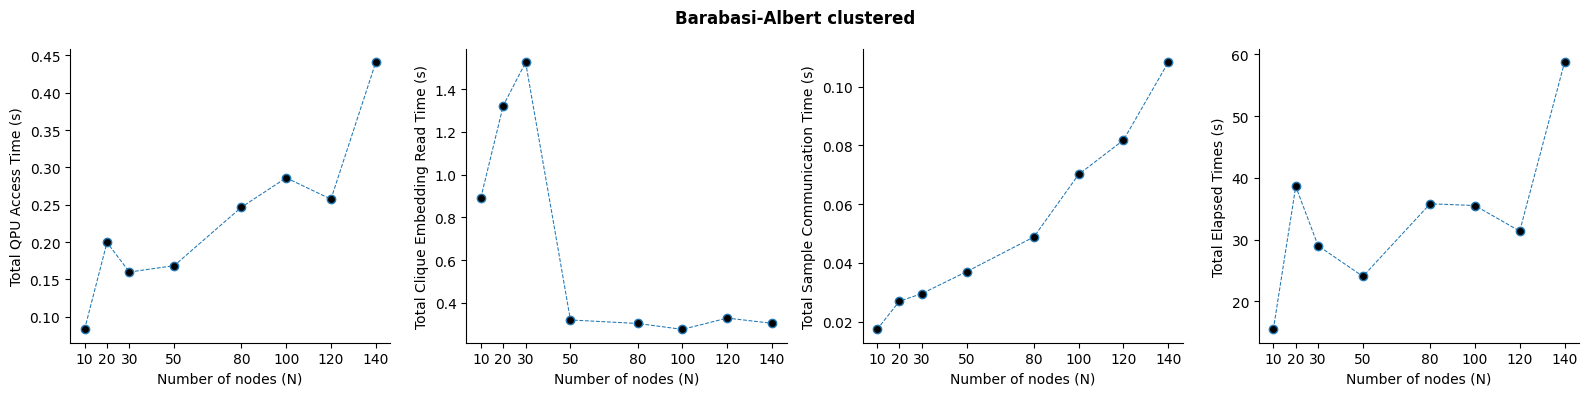

In [13]:
labels = [
    "Total QPU Access Time (s)",
    "Total Clique Embedding Read Time (s)",
    "Total Sample Communication Time (s)",
    "Total Elapsed Times (s)"
]

data = [
    qpu_total_access_time,
    clique_emb_read_total_time,
    sample_communication_total_time,
    elapsed_times
]

# Plot setup
fig, axes = plt.subplots(1, 4, figsize=(16,4), sharex=True)

for ax, times, label in zip(axes, data, labels):
    ax.plot(
        num_nodes, 
        times, 
        'o--', 
        lw=.75,
        markerfacecolor="black"
    )

    ax.spines[["top","right"]].set_visible(False)
    ax.set_ylabel(label)
    ax.set_xlabel("Number of nodes (N)")
    ax.set_xticks(num_nodes)

fig.suptitle("Barabasi-Albert clustered", fontweight="bold")
fig.tight_layout()
plt.savefig("./Anneal-Times/Barbasi-Albert/Computing-Times_full-recursion.svg", format='svg', dpi=300)

# Erdos-Renyi networks

In [2]:
os.makedirs("./Anneal-Times/Erdos-Renyi", exist_ok=True)

num_reads = 100
version = "Advantage_system6.4"
region = "na-west-1"
num_runs = 20
num_nodes = [10,20,30,50,80,100,120,140]
p = .4
resolution = 1

try:
    Graphs = np.load(f"./Anneal-Times/Erdos-Renyi/ER-graphs_NODES--{num_nodes[0]}-{num_nodes[-1]}_p-{p}.npy", allow_pickle=True)
    print("Networks loaded")
except:
    Graphs = np.empty(shape=(len(num_nodes),), dtype=object)
    for i, n in enumerate(num_nodes):
        Graphs[i] = nx.erdos_renyi_graph(n=int(n), p=p)
    np.save(f"./Anneal-Times/Erdos-Renyi/ER-graphs_NODES--{num_nodes[0]}-{num_nodes[-1]}_p-{p}.npy", Graphs)
    print("Networks saved")

Networks loaded


### Annealing times for th einitial division

In [3]:
qpu_total_access_time = np.zeros((len(num_nodes),))
clique_emb_read_total_time = np.zeros((len(num_nodes),))
sample_communication_total_time = np.zeros((len(num_nodes),))
elapsed_times = np.zeros((len(num_nodes),))
max_mods = np.zeros((len(num_nodes),))

with open(f"./Anneal-Times/Erdos-Renyi/summary-results_initial-division.txt", 'w') as file:
    for it, nodes in enumerate(num_nodes):
        try: 
            import pickle
            communities, modularities, times, division_trees, division_modularities = (
                np.load(f"./Anneal-Times/Erdos-Renyi/ER_n-{nodes}_communities.npy", allow_pickle=True), 
                np.load(f"./Anneal-Times/Erdos-Renyi/ER_n-{nodes}_modularities.npy", allow_pickle=True),
                np.load(f"./Anneal-Times/Erdos-Renyi/ER_n-{nodes}_times.npy", allow_pickle=True),
                np.load(f"./Anneal-Times/Erdos-Renyi/ER_n-{nodes}_division_trees.npy", allow_pickle=True), 
                np.load(f"./Anneal-Times/Erdos-Renyi/ER_n-{nodes}_division_modularities.npy", allow_pickle=True)
            )
            with open(f"./Anneal-Times/Erdos-Renyi/ER_n-{nodes}_samplesets_data.pkl", 'rb') as f:
                sampleset_data = pickle.load(f)
            
            print("Loaded results for nodes", nodes)
                
        except:
            print("Computing results for nodes", nodes, "( Check --> N =", len(Graphs[it].nodes()),")")

            advantage = AdvantageSampler(
                Graphs[it], # Be careful when modifying the loop to process the correct network
                resolution=resolution,
                num_reads=num_reads, 
                version=version, 
                region=region, 
                use_clique_embedding=True, 
                return_sampleset_metadata=True, 
                elapse_times=True
            )
            iterative_searcher = IterativeSearcher(sampler=advantage)

            res = iterative_searcher.run_with_sampleset_info(
                num_runs=num_runs,
                save_results=True,
                saving_path = f"./Anneal-Times/Erdos-Renyi/ER_n-{nodes}",
                iterative_verbosity=0,
                return_sampleset_metadata=True,
            )

            communities, modularities, times, division_trees, division_modularities, sampleset_data = (
                res.communities, 
                res.modularity, 
                res.time, 
                res.division_tree, 
                res.division_modularities, 
                res.samplesets_data
            )
            
        id_max = np.argmax(modularities)
        max_mods[it] = modularities.max()
        elapsed_times[it] = times[id_max]
        info = sampleset_data[id_max]

        # Readout is in microseconds, but only from the first division --> Ignore the entire tree
        qpu_sampling_time_us = info.dwave_sampleset_metadata.qpu_sampling_time_us[0] / 1e6
        qpu_anneal_time_per_sample_us = info.dwave_sampleset_metadata.qpu_anneal_time_per_sample_us[0] / 1e6 
        qpu_readout_time_per_sample_us = info.dwave_sampleset_metadata.qpu_readout_time_per_sample_us[0] / 1e6 
        qpu_access_times = info.dwave_sampleset_metadata.qpu_access_time_us[0] / 1e6 
        qpu_access_overhead_time_us = info.dwave_sampleset_metadata.qpu_access_overhead_time_us[0] / 1e6 
        qpu_programming_time_us = info.dwave_sampleset_metadata.qpu_programming_time_us[0] / 1e6 
        qpu_delay_time_per_sample_us = info.dwave_sampleset_metadata.qpu_delay_time_per_sample_us[0] / 1e6
        total_postprocess_time = info.dwave_sampleset_metadata.total_post_processing_time_us[0] / 1e6
                                       
        # Readout is in seconds, but only from the first division --> Ignore the entire tree
        clique_emb_read_time = info.time_measurements[0][0]
        sample_communication = info.time_measurements[0][2]

        file.write(f"Max modularity N={nodes} --> {max_mods[it].round(6)}\n")
        file.write("\n")
        file.write(f"Total QPU sampling time:  {qpu_sampling_time_us} (s)\n")
        file.write(f"Total QPU anneal time per sample  {qpu_anneal_time_per_sample_us} (s)\n")
        file.write(f"Total QPU readout time per sample:  {qpu_readout_time_per_sample_us} (s)\n")
        file.write(f"Total QPU access time:  {qpu_access_times}(s)\n")
        file.write(f"Total QPU access overhead time:  {qpu_access_overhead_time_us} (s)\n")
        file.write(f"Total QPU programming time:  {qpu_programming_time_us} (s)\n")
        file.write(f"Total QPU delay time per sample:  {qpu_delay_time_per_sample_us} (s)\n")
        file.write(f"Total post-processing time:  {total_postprocess_time} (s)\n")
        file.write("\n")
        file.write(f"Total cache-and-read embedding time:  {clique_emb_read_time} (s)\n")
        file.write(f"Total solver communication time:  {sample_communication} (s)\n")
        file.write("x"*50+"\n")

        # Letś record the quantities of interes
        qpu_total_access_time[it] = qpu_access_times
        clique_emb_read_total_time[it] = clique_emb_read_time
        sample_communication_total_time[it] = sample_communication

Loaded results for nodes 10
Loaded results for nodes 20
Loaded results for nodes 30
Loaded results for nodes 50
Loaded results for nodes 80
Loaded results for nodes 100
Loaded results for nodes 120
Loaded results for nodes 140


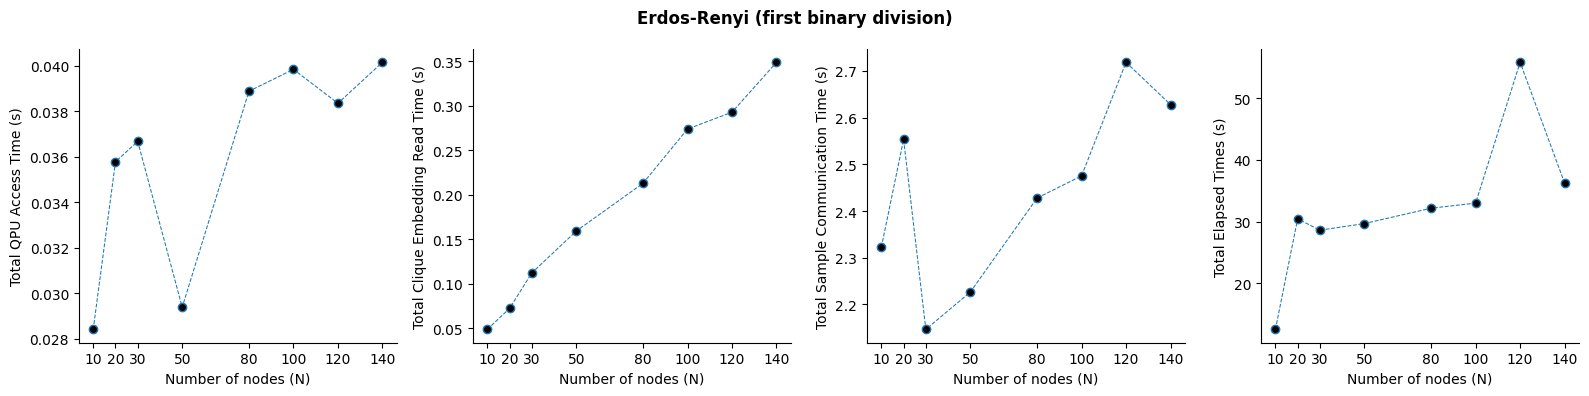

In [4]:
labels = [
    "Total QPU Access Time (s)",
    "Total Clique Embedding Read Time (s)",
    "Total Sample Communication Time (s)",
    "Total Elapsed Times (s)"
]

data = [
    qpu_total_access_time,
    clique_emb_read_total_time,
    sample_communication_total_time,
    elapsed_times
]

# Plot setup
fig, axes = plt.subplots(1, 4, figsize=(16,4), sharex=True)

for ax, times, label in zip(axes, data, labels):
    ax.plot(
        num_nodes, 
        times, 
        'o--', 
        lw=.75,
        markerfacecolor="black"
    )

    ax.spines[["top","right"]].set_visible(False)
    ax.set_ylabel(label)
    ax.set_xlabel("Number of nodes (N)")
    ax.set_xticks(num_nodes)

fig.suptitle("Erdos-Renyi (first binary division)", fontweight="bold")
fig.tight_layout()
plt.savefig("./Anneal-Times/Erdos-Renyi/Computing-Times_initial-division.svg", format='svg', dpi=300)

### Annealing times for the entire division tree

In [7]:
qpu_total_access_time = np.zeros((len(num_nodes),))
clique_emb_read_total_time = np.zeros((len(num_nodes),))
sample_communication_total_time = np.zeros((len(num_nodes),))
elapsed_times = np.zeros((len(num_nodes),))
max_mods = np.zeros((len(num_nodes),))

with open(f"./Anneal-Times/Erdos-Renyi/summary-results_full-recursion.txt", 'w') as file:
    for it, nodes in enumerate(num_nodes):
        try: 
            import pickle
            communities, modularities, times, division_trees, division_modularities = (
                np.load(f"./Anneal-Times/Erdos-Renyi/ER_n-{nodes}_communities.npy", allow_pickle=True), 
                np.load(f"./Anneal-Times/Erdos-Renyi/ER_n-{nodes}_modularities.npy", allow_pickle=True),
                np.load(f"./Anneal-Times/Erdos-Renyi/ER_n-{nodes}_times.npy", allow_pickle=True),
                np.load(f"./Anneal-Times/Erdos-Renyi/ER_n-{nodes}_division_trees.npy", allow_pickle=True), 
                np.load(f"./Anneal-Times/Erdos-Renyi/ER_n-{nodes}_division_modularities.npy", allow_pickle=True)
            )
            with open(f"./Anneal-Times/Erdos-Renyi/ER_n-{nodes}_samplesets_data.pkl", 'rb') as f:
                sampleset_data = pickle.load(f)
            
            print("Loaded results for nodes", nodes)
                
        except:
            print("Computing results for nodes", nodes, "( Check --> N =", len(Graphs[it].nodes()),")")

            advantage = AdvantageSampler(
                Graphs[it], # Be careful when modifying the loop to process the correct network
                resolution=resolution,
                num_reads=num_reads, 
                version=version, 
                region=region, 
                use_clique_embedding=True, 
                return_sampleset_metadata=True, 
                elapse_times=True
            )
            iterative_searcher = IterativeSearcher(sampler=advantage)

            res = iterative_searcher.run_with_sampleset_info(
                num_runs=num_runs,
                save_results=True,
                saving_path = f"./Anneal-Times/Erdos-Renyi/ER_n-{nodes}",
                iterative_verbosity=0,
                return_sampleset_metadata=True,
            )

            communities, modularities, times, division_trees, division_modularities, sampleset_data = (
                res.communities, 
                res.modularity, 
                res.time, 
                res.division_tree, 
                res.division_modularities, 
                res.samplesets_data
            )
        id_max = np.argmax(modularities)
        max_mods[it] = modularities.max()
        elapsed_times[it] = times[id_max]
        info = sampleset_data[id_max]

        # Readout is in microseconds, but only from the first division --> Ignore the entire tree
        qpu_sampling_time_us = sum( info.dwave_sampleset_metadata.qpu_sampling_time_us / 1e6 )
        qpu_anneal_time_per_sample_us = sum( info.dwave_sampleset_metadata.qpu_anneal_time_per_sample_us / 1e6 )
        qpu_readout_time_per_sample_us = sum( info.dwave_sampleset_metadata.qpu_readout_time_per_sample_us / 1e6 )
        qpu_access_times = sum( info.dwave_sampleset_metadata.qpu_access_time_us / 1e6 )
        qpu_access_overhead_time_us = sum( info.dwave_sampleset_metadata.qpu_access_overhead_time_us / 1e6 )
        qpu_programming_time_us = sum( info.dwave_sampleset_metadata.qpu_programming_time_us / 1e6 )
        qpu_delay_time_per_sample_us = sum( info.dwave_sampleset_metadata.qpu_delay_time_per_sample_us / 1e6 )
        total_postprocess_time = sum( info.dwave_sampleset_metadata.total_post_processing_time_us / 1e6 )
                                       
        # Readout is in seconds, but only from the first division --> Ignore the entire tree
        clique_emb_read_time = sum( [info.time_measurements[i][0] for i in range(len(division_trees[id_max]))] )
        sample_communication = sum( [info.time_measurements[i][2] for i in range(len(division_trees[id_max]))] )

        file.write(f"Max modularity N={nodes} --> {max_mods[it].round(6)}\n")
        file.write("\n")
        file.write(f"Total QPU sampling time:  {qpu_sampling_time_us} (s)\n")
        file.write(f"Total QPU anneal time per sample  {qpu_anneal_time_per_sample_us} (s)\n")
        file.write(f"Total QPU readout time per sample:  {qpu_readout_time_per_sample_us} (s)\n")
        file.write(f"Total QPU access time:  {qpu_access_times}(s)\n")
        file.write(f"Total QPU access overhead time:  {qpu_access_overhead_time_us} (s)\n")
        file.write(f"Total QPU programming time:  {qpu_programming_time_us} (s)\n")
        file.write(f"Total QPU delay time per sample:  {qpu_delay_time_per_sample_us} (s)\n")
        file.write(f"Total post-processing time:  {total_postprocess_time} (s)\n")
        file.write("\n")
        file.write(f"Total cache-and-read embedding time:  {clique_emb_read_time} (s)\n")
        file.write(f"Total solver communication time:  {sample_communication} (s)\n")
        file.write("x"*50+"\n")

        # Letś record the quantities of interes
        qpu_total_access_time[it] = qpu_access_times
        clique_emb_read_total_time[it] = clique_emb_read_time
        sample_communication_total_time[it] = sample_communication

Loaded results for nodes 10
Loaded results for nodes 20
Loaded results for nodes 30
Loaded results for nodes 50
Loaded results for nodes 80
Loaded results for nodes 100
Computing results for nodes 120 ( Check --> N = 120 )


100%|██████████| 20/20 [11:01<00:00, 33.08s/it]

Loaded results for nodes 140


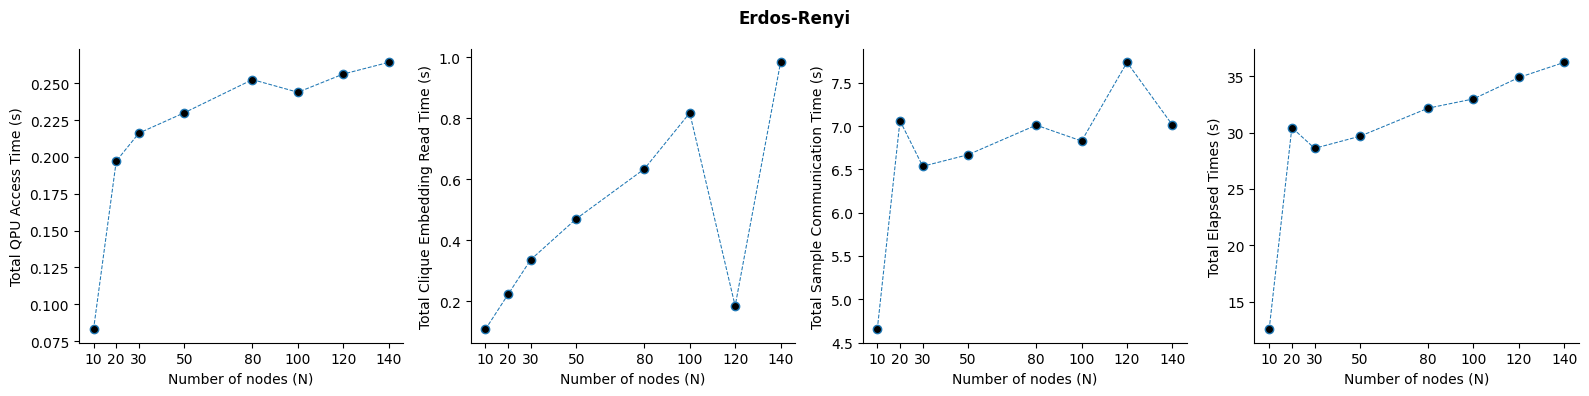

In [8]:
labels = [
    "Total QPU Access Time (s)",
    "Total Clique Embedding Read Time (s)",
    "Total Sample Communication Time (s)",
    "Total Elapsed Times (s)"
]

data = [
    qpu_total_access_time,
    clique_emb_read_total_time,
    sample_communication_total_time,
    elapsed_times
]

# Plot setup
fig, axes = plt.subplots(1, 4, figsize=(16,4), sharex=True)

for ax, times, label in zip(axes, data, labels):
    ax.plot(
        num_nodes, 
        times, 
        'o--', 
        lw=.75,
        markerfacecolor="black"
    )

    ax.spines[["top","right"]].set_visible(False)
    ax.set_ylabel(label)
    ax.set_xlabel("Number of nodes (N)")
    ax.set_xticks(num_nodes)

fig.suptitle("Erdos-Renyi", fontweight="bold")
fig.tight_layout()
plt.savefig("./Anneal-Times/Erdos-Renyi/Computing-Times_full-recursion.svg", format='svg', dpi=300)

### Resolutions

In [5]:
resolutions = [.5, .75, 1.25, 1.5]#1, 
nodes_resolutions = [50, 80, 100]
qpu_total_access_time_resos = np.zeros((len(resolutions),len(nodes_resolutions)))
clique_emb_read_total_time_resos = np.zeros((len(resolutions),len(nodes_resolutions)))
sample_communication_total_time_resos = np.zeros((len(resolutions),len(nodes_resolutions)))
elapsed_times_resos = np.zeros((len(resolutions),len(nodes_resolutions)))
max_mods_resos = np.zeros((len(resolutions),len(nodes_resolutions)))
nodes2graph = {
    10: 0,
    20: 1,
    30: 2,
    50: 3,
    80: 4,
    100: 5,
    120: 6,
    140: 7,
}

with open(f"./Anneal-Times/Erdos-Renyi/summary-results_full-recursion_resolutions.txt", 'w') as file:
    for jt, nodes in enumerate(nodes_resolutions): 
        it_gr = nodes2graph[nodes]
        for it, resolution in enumerate(resolutions):
            if resolution==1:
                text = ""
            else:
                text = f'res-{resolution}'
            try: 
                import pickle
                communities, modularities, times, division_trees, division_modularities = (
                    np.load(f"./Anneal-Times/Erdos-Renyi/ER_n-{nodes}{text}_communities.npy", allow_pickle=True), 
                    np.load(f"./Anneal-Times/Erdos-Renyi/ER_n-{nodes}{text}_modularities.npy", allow_pickle=True),
                    np.load(f"./Anneal-Times/Erdos-Renyi/ER_n-{nodes}{text}_times.npy", allow_pickle=True),
                    np.load(f"./Anneal-Times/Erdos-Renyi/ER_n-{nodes}{text}_division_trees.npy", allow_pickle=True), 
                    np.load(f"./Anneal-Times/Erdos-Renyi/ER_n-{nodes}{text}_division_modularities.npy", allow_pickle=True)
                )
                with open(f"./Anneal-Times/Erdos-Renyi/ER_n-{nodes}{text}_samplesets_data.pkl", 'rb') as f:
                    sampleset_data = pickle.load(f)
                
                print("Loaded results for", nodes, "and resolution ", resolution)
                    
            except:
                print("Computing results for nodes", nodes, "and resolution ", resolution, "( Check --> N =", len(Graphs[it_gr].nodes()),")")

                advantage = AdvantageSampler(
                    Graphs[it_gr], # Be careful when modifying the loop to process the correct network
                    resolution=resolution,
                    num_reads=num_reads, 
                    version=version, 
                    region=region, 
                    use_clique_embedding=True, 
                    return_sampleset_metadata=True, 
                    elapse_times=True
                )
                iterative_searcher = IterativeSearcher(sampler=advantage)

                res = iterative_searcher.run_with_sampleset_info(
                    num_runs=num_runs,
                    save_results=True,
                    saving_path = f"./Anneal-Times/Erdos-Renyi/ER_n-{nodes}{text}",
                    iterative_verbosity=0,
                    return_sampleset_metadata=True,
                )

                communities, modularities, times, division_trees, division_modularities, sampleset_data = (
                    res.communities, 
                    res.modularity, 
                    res.time, 
                    res.division_tree, 
                    res.division_modularities, 
                    res.samplesets_data
                )
                
            id_max = np.argmax(modularities)
            max_mods_resos[it,jt] = modularities.max()
            elapsed_times_resos[it,jt] = times[id_max]
            info = sampleset_data[id_max]

            # Readout is in microseconds, but only from the first division --> Ignore the entire tree
            qpu_sampling_time_us = sum( info.dwave_sampleset_metadata.qpu_sampling_time_us / 1e6 )
            qpu_anneal_time_per_sample_us = sum( info.dwave_sampleset_metadata.qpu_anneal_time_per_sample_us / 1e6 )
            qpu_readout_time_per_sample_us = sum( info.dwave_sampleset_metadata.qpu_readout_time_per_sample_us / 1e6 )
            qpu_access_times = sum( info.dwave_sampleset_metadata.qpu_access_time_us / 1e6 )
            qpu_access_overhead_time_us = sum( info.dwave_sampleset_metadata.qpu_access_overhead_time_us / 1e6 )
            qpu_programming_time_us = sum( info.dwave_sampleset_metadata.qpu_programming_time_us / 1e6 )
            qpu_delay_time_per_sample_us = sum( info.dwave_sampleset_metadata.qpu_delay_time_per_sample_us / 1e6 )
            total_postprocess_time = sum( info.dwave_sampleset_metadata.total_post_processing_time_us / 1e6 )
                                        
            # Readout is in seconds, but only from the first division --> Ignore the entire tree
            clique_emb_read_time = sum( [info.time_measurements[i][0] for i in range(len(division_trees[id_max]))] )
            sample_communication = sum( [info.time_measurements[i][2] for i in range(len(division_trees[id_max]))] )

            file.write(f"Max modularity N={nodes} --> {max_mods_resos[it].round(6)}\n")
            file.write("\n")
            file.write(f"Total QPU sampling time:  {qpu_sampling_time_us} (s)\n")
            file.write(f"Total QPU anneal time per sample  {qpu_anneal_time_per_sample_us} (s)\n")
            file.write(f"Total QPU readout time per sample:  {qpu_readout_time_per_sample_us} (s)\n")
            file.write(f"Total QPU access time:  {qpu_access_times}(s)\n")
            file.write(f"Total QPU access overhead time:  {qpu_access_overhead_time_us} (s)\n")
            file.write(f"Total QPU programming time:  {qpu_programming_time_us} (s)\n")
            file.write(f"Total QPU delay time per sample:  {qpu_delay_time_per_sample_us} (s)\n")
            file.write(f"Total post-processing time:  {total_postprocess_time} (s)\n")
            file.write("\n")
            file.write(f"Total cache-and-read embedding time:  {clique_emb_read_time} (s)\n")
            file.write(f"Total solver communication time:  {sample_communication} (s)\n")
            file.write("x"*50+"\n")

            # Letś record the quantities of interes
            qpu_total_access_time_resos[it,jt] = qpu_access_times
            clique_emb_read_total_time_resos[it,jt] = clique_emb_read_time
            sample_communication_total_time_resos[it,jt] = sample_communication
        print("")

Loaded results for 50 and resolution  0.5
Loaded results for 50 and resolution  0.75
Loaded results for 50 and resolution  1.25
Loaded results for 50 and resolution  1.5

Loaded results for 80 and resolution  0.5
Loaded results for 80 and resolution  0.75
Loaded results for 80 and resolution  1.25
Loaded results for 80 and resolution  1.5

Loaded results for 100 and resolution  0.5
Loaded results for 100 and resolution  0.75
Loaded results for 100 and resolution  1.25
Loaded results for 100 and resolution  1.5

